## Effect of median income on business types available.

The aim of this workbook is to analyse the business types available in Perth suburbs with different average incomes.

### Introduction
This information would be useful for business owners who are trying to find a new location for a specific type of business.
### Data 
The data used will be sourced from FourSquare, wikipedia and the australian census.
### Methodology 
the analysis will require linking suburb names with their respective postcodes, we will then find the ten most common business types available in each suburb.
after which, we will append median income to each suburb and work out an appropriate number of groups before using machine learning tools to group them.
after which we will attempt to create a profile for each group
Results section where you discuss the results.
Discussion section where you discuss any observations you noted and any recommendations you can make based on the results.
Conclusion section where you conclude the report.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [2]:
CLIENT_ID = 'ZSTKZCQ3JJ52O4HMGJI1F44TMAKYFP5RX3HYH4YVYFQHKBQQ' # your Foursquare ID
CLIENT_SECRET = 'IGQFK3UO1KC0AWBBJW5TZAVS5SFAWG3EFJNRUIGDTARN4DEL' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZSTKZCQ3JJ52O4HMGJI1F44TMAKYFP5RX3HYH4YVYFQHKBQQ
CLIENT_SECRET:IGQFK3UO1KC0AWBBJW5TZAVS5SFAWG3EFJNRUIGDTARN4DEL


In [3]:
from bs4 import BeautifulSoup
# Import required packages
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
!pip install geocoder

In [4]:
!wget -O census_data.csv https://data.gov.au/data/dataset/540e3eac-f2df-48d1-9bc0-fbe8dfec641f/resource/d2804aa6-4c32-453c-9d60-d957e9028952/download/ts17individual25countaveragemedianbypostcode.csv

--2019-11-26 14:25:34--  https://data.gov.au/data/dataset/540e3eac-f2df-48d1-9bc0-fbe8dfec641f/resource/d2804aa6-4c32-453c-9d60-d957e9028952/download/ts17individual25countaveragemedianbypostcode.csv
Resolving data.gov.au (data.gov.au)... 52.63.65.1, 52.62.106.0, 2406:da1c:19:c600:850c:f436:4737:d38f, ...
Connecting to data.gov.au (data.gov.au)|52.63.65.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444293 (434K) [text/csv]
Saving to: ‘census_data.csv’

100%[======================================>] 444,293      495KB/s   in 0.9s   

2019-11-26 14:25:35 (495 KB/s) - ‘census_data.csv’ saved [444293/444293]



In [5]:
!wget -O au.zip https://download.geonames.org/export/zip/AU.zip

--2019-11-26 14:25:36--  https://download.geonames.org/export/zip/AU.zip
Resolving download.geonames.org (download.geonames.org)... 188.40.33.19
Connecting to download.geonames.org (download.geonames.org)|188.40.33.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255411 (249K) [application/zip]
Saving to: ‘au.zip’

100%[======================================>] 255,411      505KB/s   in 0.5s   

2019-11-26 14:25:38 (505 KB/s) - ‘au.zip’ saved [255411/255411]



In [6]:
import zipfile

In [7]:
aus_pc = []
with zipfile.ZipFile("au.zip", "r") as zf:
    data = zf.read("AU.txt").decode("utf-8").split("\n")[:-1]
    for row in data:
        cols = row.replace("\t\t\t","").split("\t")
        aus_pc.append({"country":cols[0],
                       "postcode":cols[1],
                       "suburb":cols[2],
                       "state_territory":cols[3],
                       "state_territory_code":cols[4],
                       "city":cols[5],
                       "latitude":cols[6],
                       "longitude":cols[7],
                       "id":cols[8]})
df_aus_pc = pd.DataFrame(aus_pc)
df_aus_pc.head()

city country id  latitude longitude postcode  \
0        CANBERRA      AU  1  -35.2777  149.1189     0200   
1                      AU  4  -35.3049  149.1412     0221   
2  NEW CNTRY WEST      AU  4  -35.1499  150.6969     2540   
3                      AU  4  -35.1648  150.6908     2540   
4  NEW CNTRY WEST      AU  3   -35.028  150.5501     2540   

                state_territory state_territory_code  \
0  Australian Capital Territory                  ACT   
1  Australian Capital Territory                  ACT   
2  Australian Capital Territory                  ACT   
3  Australian Capital Territory                  ACT   
4  Australian Capital Territory                  ACT   

                           suburb  
0  Australian National University  
1                          Barton  
2                      Jervis Bay  
3                       Wreck Bay  
4                   Hmas Creswell

In [8]:
df_cencus = pd.read_csv("census_data.csv")

In [9]:
df_wa = df_aus_pc.loc[df_aus_pc['state_territory_code']=='WA']
print(df_wa.city.unique())

['' 'CURTIN' 'STIRLING' 'BRAND' 'TANGNEY' 'KALGOORLIE']


In [10]:
df_wa[['latitude','longitude']] = df_wa[['latitude','longitude']].astype(float)

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [11]:
df_wa = df_wa[df_wa['city'] != 'BRAND']
df_wa = df_wa[df_wa['city'] != 'KALGOORLIE']
df_wa = df_wa[df_wa['city'] != '']
df_wa[['latitude','longitude']] = df_wa[['latitude','longitude']].astype(float)
print(df_wa.city.unique())


['CURTIN' 'STIRLING' 'TANGNEY']


In [12]:
from IPython.display import HTML, display
map_wa = folium.Map(location=[-31, 115], zoom_start=7)

In [13]:
# add markers to map
for lat, lng, borough, neighborhood in zip(df_wa['latitude'], df_wa['longitude'], df_wa['city'], df_wa['suburb']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_wa)  
    
display(map_wa)

In [14]:
def getNearbyVenues(name, lat, lng, radius=5000):
    
    venues_list=[]
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}'.format(
    CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, "", radius)


            
        # make the GET request
    results = requests.get(url).json()['response']['venues']
    
        # return only relevant information for each nearby venue
    for v in results:
        if len(v['categories']) == 0:
            continue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['shortName']) ])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print(nearby_venues)
    return(nearby_venues)

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [15]:
wa_venues = list()
print(df_wa.head())
for index, row in df_wa.iterrows():
    try:
        print(row)
        print(row["suburb"])
        wa_venues.append(getNearbyVenues(row['suburb'],
                                       row['latitude'],
                                       row['longitude']
                                      ))
    except Exception as e:
        print(e)

         city country id  latitude  longitude postcode    state_territory  \
14979  CURTIN      AU  4  -31.9543   115.8587     6000  Western Australia   
14983  CURTIN      AU  4  -31.9404   115.8708     6003  Western Australia   
14984  CURTIN      AU  4  -31.9461   115.8559     6003  Western Australia   
14985  CURTIN      AU  4  -31.9426   115.8791     6004  Western Australia   
14986  CURTIN      AU  4  -31.9392   115.8514     6005  Western Australia   

      state_territory_code       suburb  
14979                   WA        Perth  
14983                   WA     Highgate  
14984                   WA  Northbridge  
14985                   WA   East Perth  
14986                   WA   West Perth  
city                               CURTIN
country                                AU
id                                      4
latitude                         -31.9543
longitude                         115.859
postcode                             6000
state_territory         Western A

In [16]:
print(df_wa.shape)

(352, 9)


In [17]:
df_wa_venues = pd.concat(wa_venues)

In [ ]:
df_wa_venues.rename(columns={'Neighborhood':'suburb'},inplace=True)

In [18]:
df_wa_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0        Perth               -31.9543                115.8587   
1        Perth               -31.9543                115.8587   
2        Perth               -31.9543                115.8587   
3        Perth               -31.9543                115.8587   
4        Perth               -31.9543                115.8587   

                   Venue  Venue Latitude  Venue Longitude Venue Category  
0            Mo Espresso      -31.954294       115.858581    Coffee Shop  
1          Culture Kings      -31.954162       115.858707        Apparel  
2  Infusion Coffee & Tea      -31.954110       115.859327    Coffee Shop  
3          Telstra Store      -31.954185       115.858655    Electronics  
4             Meet & Bun      -31.954331       115.858501        Burgers

In [21]:
# one hot encoding
wa_onehot = pd.get_dummies(df_wa_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
wa_onehot['Neighborhood'] = df_wa_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [wa_onehot.columns[-1]] + list(wa_onehot.columns[:-1])
wa_onehot = wa_onehot[fixed_columns]

wa_onehot.head()

Neighborhood  ATM  Academic Building  Accessories  Administrative Building  \
0        Perth    0                  0            0                        0   
1        Perth    0                  0            0                        0   
2        Perth    0                  0            0                        0   
3        Perth    0                  0            0                        0   
4        Perth    0                  0            0                        0   

   Adult Boutique  Afghan  African  Airport  Airport Service  \
0               0       0        0        0                0   
1               0       0        0        0                0   
2               0       0        0        0                0   
3               0       0        0        0                0   
4               0       0        0        0                0   

   Alternative Healer  American  Animal Shelter  Antiques  Apparel  \
0                   0         0               0         0        0   
1                   0         0               0         0        1   
2                   0         0               0         0        0   
3                   0         0               0         0        0   
4                   0         0               0         0        0   

   Apres Ski Bar  Aquarium  Arcade  Art Gallery  Art Studio  Arts  \
0              0         0       0            0           0     0   
1              0         0       0            0           0     0   
2              0         0       0            0           0     0   
3              0         0       0            0           0     0   
4              0         0       0            0           0     0   

   Arts & Crafts  Arts & Entertainment  Asian  Assisted Living  \
0              0                     0      0                0   
1              0                     0      0                0   
2              0                     0      0                0   
3              0                     0      0                0   
4              0                     0      0                0   

   Athletics & Sports  Auditorium  Australian  Auto Dealer  Auto Garage  \
0                   0           0           0            0            0   
1                   0           0           0            0            0   
2                   0           0           0            0            0   
3                   0           0           0            0            0   
4                   0           0           0            0            0   

   Auto Workshop  Automotive  B & B  BBQ  Bakery  Bank  Bar  Baseball Field  \
0              0           0      0    0       0     0    0               0   
1              0           0      0    0       0     0    0               0   
2              0           0      0    0       0     0    0               0   
3              0           0      0    0       0     0    0               0   
4              0           0      0    0       0     0    0               0   

   Basketball  Basketball Court  Beach  Beer Bar  Beer Garden  Beer Store  \
0           0                 0      0         0            0           0   
1           0                 0      0         0            0           0   
2           0                 0      0         0            0           0   
3           0                 0      0         0            0           0   
4           0                 0      0         0            0           0   

   Big Box Store  Bike Shop  Billiards  Bistro  Board Shop  Boat / Ferry  \
0              0          0          0       0           0             0   
1              0          0          0       0           0             0   
2              0          0          0       0           0             0   
3              0          0          0       0           0             0   
4              0          0          0       0           0             0   

   Bookstore  Boutique  Bowling Alley  Bowling Green  Box

In [22]:
df_postcodes = df_wa[['suburb','postcode']]
wa_grouped = wa_onehot.groupby('Neighborhood').mean().reset_index()
wa_grouped

Neighborhood       ATM  Academic Building  Accessories  \
0            Alexander Heights  0.000000           0.000000     0.000000   
1                      Alkimos  0.000000           0.000000     0.000000   
2                     Armadale  0.000000           0.000000     0.000000   
3                        Ascot  0.000000           0.000000     0.000000   
4                     Ashfield  0.000000           0.041667     0.000000   
5                   Australind  0.000000           0.000000     0.000000   
6                     Balcatta  0.000000           0.000000     0.000000   
7                        Balga  0.000000           0.000000     0.000000   
8                    Ballajura  0.000000           0.000000     0.000000   
9                Banksia Grove  0.000000           0.000000     0.000000   
10                 Baskerville  0.000000           0.000000     0.000000   
11                  Bassendean  0.000000           0.017241     0.000000   
12               Bassendean Dc  0.000000           0.000000     0.000000   
13                   Bayswater  0.000000           0.000000     0.000000   
14                   Beckenham  0.000000           0.000000     0.000000   
15                     Bedford  0.000000           0.000000     0.000000   
16                  Bedfordale  0.000000           0.000000     0.000000   
17                   Beechboro  0.000000           0.000000     0.000000   
18                      Beldon  0.000000           0.000000     0.000000   
19                      Belhus  0.000000           0.000000     0.000000   
20                    Bellevue  0.000000           0.000000     0.000000   
21                     Belmont  0.000000           0.000000     0.000000   
22                     Bentley  0.000000           0.000000     0.000000   
23                  Bentley Dc  0.000000           0.000000     0.000000   
24                     Bickley  0.000000           0.000000     0.000000   
25                   Binningup  0.000000           0.000000     0.000000   
26                        Boya  0.000000           0.000000     0.000000   
27                  Breton Bay  0.000000           0.000000     0.000000   
28                   Brigadoon  0.000000           0.000000     0.000000   
29           Broadway Nedlands  0.000000           0.000000     0.000000   
30                   Brookdale  0.000000           0.000000     0.000000   
31                  Bull Creek  0.000000           0.000000     0.000000   
32                  Bullsbrook  0.000000           0.000000     0.000000   
33                     Bunbury  0.000000           0.000000     0.000000   
34                 Burns Beach  0.000000           0.000000     0.000000   
35                    Burswood  0.000000           0.000000     0.000000   
36                      Butler  0.000000           0.000000     0.000000   
37                      Byford  0.000000           0.000000     0.000000   
38               Canning Mills  0.000000           0.000000     0.000000   
39                Canning Vale  0.000000           0.000000     0.000000   
40             Canning Vale Dc  0.000000           0.000000     0.000000   
41          Canning Vale South  0.000000           0.000000     0.000000   
42                  Cannington  0.000000           0.000000     0.000000   
43                     Caraban  0.000000           0.000000     0.000000   
44                   Carabooda  0.000000           0.000000     0.000000   
45                      Cardup  0.000000           0.000000     0.000000   
46                  Carey Park  0.000000           0.000000     0.000000   
47                      Carine  0.000000           0.000000     0.000000   
48                    Carlisle  0.000000           0.000000     0.000000   
49                      Carmel  0.000000           0.000000     0.000000   
50                    Carramar  0.000000           0.000000     0.000000   
51                   Caversham  0.000000           0.000000     0.

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = wa_grouped['Neighborhood']

for ind in np.arange(wa_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(wa_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0  Alexander Heights                   Pub                  Café   
1            Alkimos                  Park           Real Estate   
2           Armadale                  Café            Food Truck   
3              Ascot              Building            Automotive   
4           Ashfield                Office               Parking   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                   Bus                Indian               Brewery   
1   Housing Development             Fast Food               Italian   
2      Department Store           Supermarket           Coffee Shop   
3                 Hotel             Fast Food         Veterinarians   
4               Italian               Factory          Liquor Store   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0           Gas Station       Doctor's Office            Vietnamese   
1        Other Outdoors         Gym / Fitness         Train Station   
2              Pharmacy                   Pub      Dentist's Office   
3             Gift Shop            Playground                Office   
4            Australian           Event Space                  Shop   

  9th Most Common Venue 10th Most Common Venue  
0             Gift Shop         Middle Eastern  
1                School                  Malay  
2         Big Box Store                    Bar  
3                Resort            Bus Station  
4         Grocery Store           Soccer Field

In [41]:
df_census = pd.read_csv("census_data.csv")
df_income = df_census[['Postcode','Median taxable income or loss']]
df_income.rename(columns={'Postcode':'postcode','Median taxable income or loss':'median income'},inplace=True)
print(df_income.dtypes)
df_postcodes = df_wa[['suburb','postcode']]
df_postcodes['postcode'] = df_postcodes['postcode'].astype(int)
df_postcodes = df_postcodes.join(df_income.set_index('postcode'), on='postcode')
df_postcodes.head()

postcode         int64
median income    int64
dtype: object


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


suburb  postcode  median income
14979        Perth      6000        46265.0
14983     Highgate      6003        45517.0
14984  Northbridge      6003        45517.0
14985   East Perth      6004        48495.0
14986   West Perth      6005        52929.0

In [35]:
neighborhoods_venues_sorted.head()

suburb 1st Most Common Venue 2nd Most Common Venue  \
0  Alexander Heights                   Pub                  Café   
1            Alkimos                  Park           Real Estate   
2           Armadale                  Café            Food Truck   
3              Ascot              Building            Automotive   
4           Ashfield                Office               Parking   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                   Bus                Indian               Brewery   
1   Housing Development             Fast Food               Italian   
2      Department Store           Supermarket           Coffee Shop   
3                 Hotel             Fast Food         Veterinarians   
4               Italian               Factory          Liquor Store   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0           Gas Station       Doctor's Office            Vietnamese   
1        Other Outdoors         Gym / Fitness         Train Station   
2              Pharmacy                   Pub      Dentist's Office   
3             Gift Shop            Playground                Office   
4            Australian           Event Space                  Shop   

  9th Most Common Venue 10th Most Common Venue  
0             Gift Shop         Middle Eastern  
1                School                  Malay  
2         Big Box Store                    Bar  
3                Resort            Bus Station  
4         Grocery Store           Soccer Field

In [47]:
neighborhoods_venues_sorted.rename(columns={'Neighborhood':'suburb'},inplace=True)
df_wa_full = neighborhoods_venues_sorted.join(df_postcodes.set_index('suburb'), on='suburb').dropna()
df_wa_full.head()

suburb 1st Most Common Venue 2nd Most Common Venue  \
0  Alexander Heights                   Pub                  Café   
2           Armadale                  Café            Food Truck   
3              Ascot              Building            Automotive   
4           Ashfield                Office               Parking   
5         Australind           Post Office                   Gym   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                   Bus                Indian               Brewery   
2      Department Store           Supermarket           Coffee Shop   
3                 Hotel             Fast Food         Veterinarians   
4               Italian               Factory          Liquor Store   
5            Automotive        Medical Supply                School   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0           Gas Station       Doctor's Office            Vietnamese   
2              Pharmacy                   Pub      Dentist's Office   
3             Gift Shop            Playground                Office   
4            Australian           Event Space                  Shop   
5                  Mall               Chinese              Hardware   

  9th Most Common Venue 10th Most Common Venue  postcode  median income  
0             Gift Shop         Middle Eastern      6064        40654.0  
2         Big Box Store                    Bar      6112        48235.0  
3                Resort            Bus Station      6104        47461.0  
4         Grocery Store           Soccer Field      6054        47563.0  
5       Harbor / Marina           Food & Drink      6233        46679.0

In [45]:
df_wa_features.shape

(272, 13)

In [50]:
df_wa_features = df_wa_full.drop("suburb", axis=1).drop("postcode", axis=1)

cols = list()
for col in df_wa_features.columns:
    if col == "median income":
        continue
    cols.append(col)
df_wa_features_tmp = df_wa_features
print(cols)
for col in cols:
    dummies = pd.get_dummies(df_wa_features[col], prefix=col)
    df_wa_features = pd.concat([df_wa_features, dummies], axis=1)
    df_wa_features.drop(col, axis=1, inplace=True)
df_wa_features.head()

['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue', '6th Most Common Venue', '7th Most Common Venue', '8th Most Common Venue', '9th Most Common Venue', '10th Most Common Venue']


median income  1st Most Common Venue_Academic Building  \
0        40654.0                                        0   
2        48235.0                                        0   
3        47461.0                                        0   
4        47563.0                                        0   
5        46679.0                                        0   

   1st Most Common Venue_Antiques  1st Most Common Venue_Apparel  \
0                               0                              0   
2                               0                              0   
3                               0                              0   
4                               0                              0   
5                               0                              0   

   1st Most Common Venue_Asian  1st Most Common Venue_Australian  \
0                            0                                 0   
2                            0                                 0   
3                            0                                 0   
4                            0                                 0   
5                            0                                 0   

   1st Most Common Venue_Automotive  1st Most Common Venue_Bakery  \
0                                 0                             0   
2                                 0                             0   
3                                 0                             0   
4                                 0                             0   
5                                 0                             0   

   1st Most Common Venue_Bank  1st Most Common Venue_Bar  \
0                           0                          0   
2                           0                          0   
3                           0                          0   
4                           0                          0   
5                           0                          0   

   1st Most Common Venue_Beach  1st Most Common Venue_Brewery  \
0                            0                              0   
2                            0                              0   
3                            0                              0   
4                            0                              0   
5                            0                              0   

   1st Most Common Venue_Building  1st Most Common Venue_Bus  \
0                               0                          0   
2                               0                          0   
3                               1                          0   
4                               0                          0   
5                               0                          0   

   1st Most Common Venue_Bus Station  1st Most Common Venue_Bus Stop  \
0                                  0                               0   
2                                  0                               0   
3                                  0                               0   
4                                  0                               0   
5                                  0                               0   

   1st Most Common Venue_Café  1st Most Common Venue_Campground  \
0                           0                                 0   
2                           1                                 0   
3                           0                                 0   
4                           0                                 0   
5                           0                                 0   

   1st Most Common Venue_Casino  1st Most Common Venue_Church  \
0                             0                             0   
2                             0                             0   
3                             0                             0   
4                             0                             0   
5                             0                             0   

   1st Most Common Venue_Classroom  1st

In [51]:

ss_wa = StandardScaler()
ss_wa.fit(df_wa_features)
ss_data_transformed = ss_wa.transform(df_wa_features)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.


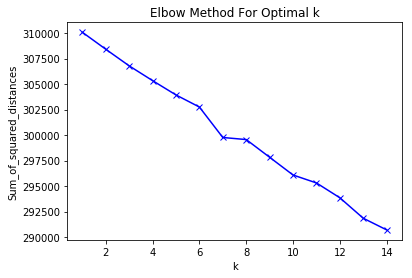

In [52]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(ss_data_transformed)
    Sum_of_squared_distances.append(km.inertia_)
    
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [59]:
# set number of clusters
kclusters = 5

##wa_grouped_clustering = df_wa_full.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_wa_features)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 1, 1, 1, 1, 1, 2, 2, 1, 1], dtype=int32)

In [61]:
print(df_wa_full.shape)
print(kmeans.labels_.shape)
df_wa_full.insert(0, 'Cluster Labels', kmeans.labels_)

wa_merged.shape() # check the last columns!

(272, 14)
(272,)


ValueError: cannot insert Cluster Labels, already exists

In [68]:
print(df_wa.dtypes)
df_wa_full['postcode'] = df_wa_full['postcode'].astype(str)
df_wa_merged =df_wa_full.merge(df_wa, how='left')

city                     object
country                  object
id                       object
latitude                float64
longitude               float64
postcode                 object
state_territory          object
state_territory_code     object
suburb                   object
dtype: object


In [73]:
# create mapmap_wa = folium.Map(location=[, ], zoom_start=7)
map_clusters = folium.Map(location=[-31, 115], zoom_start=8)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_wa_merged['latitude'], df_wa_merged['longitude'], df_wa_merged['suburb'], df_wa_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [77]:
df_wa_merged.loc[df_wa_merged['Cluster Labels'] == 0, df_wa_merged.columns[[1] + list(range(5, df_wa_merged.shape[1]))]]

suburb 4th Most Common Venue 5th Most Common Venue  \
51         City Beach           Residential            Restaurant   
52          Claremont         Women's Store           High School   
53    Claremont North           High School          Soccer Field   
60          Cottesloe      Furniture / Home           Coffee Shop   
65            Daglish         Hospital Ward               Cricket   
127        Karrakatta                 Field              Hospital   
144       Leederville          Liquor Store                 Pizza   
154            Malaga      Furniture / Home           Electronics   
173   Mount Claremont                  Café           Event Space   
202  Peppermint Grove                  Café               Jewelry   
223      Shenton Park        Animal Shelter               Italian   
233           Subiaco                  Café                 Asian   
235        Swanbourne          Liquor Store                Travel   
253         Welshpool               Factory               Medical   
256  West Leederville           Flower Shop           Coffee Shop   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
51       Basketball Court              Pharmacy       Health & Beauty   
52            Art Gallery                  Park                 Pizza   
53                  Pizza       Farmer's Market       Assisted Living   
60               Boutique               Library           High School   
65       Maternity Clinic    Athletics & Sports             Education   
127              Cemetery           Residential               Medical   
144    Salon / Barbershop           Coffee Shop               Parking   
154                   Pub              Building        Sporting Goods   
173               Jewelry                 Shops            Auditorium   
202             Fast Food                  Shop              Hardware   
223              Hospital              Building                   Bus   
233                Church    Salon / Barbershop              Bus Stop   
235              Campaign           Art Gallery               Seafood   
253           Auto Garage         Garden Center              Hardware   
256             Gift Shop                 Malay         Train Station   

    9th Most Common Venue 10th Most Common Venue postcode  median income  \
51     Salon / Barbershop             Playground     6015        61898.0   
52            Golf Course        Harbor / Marina     6010        56734.0   
53                Jewelry            Art Gallery     6010        56734.0   
60            Supermarket          Train Station     6011        68586.0   
65            Electronics                    Bar     6008        58778.0   
127                   Gym          Train Station     6010        56734.0   
144         Grocery Store                   Bank     6007        59885.0   
154                  Café            Coffee Shop     6090        56642.0   
173                Church                  Trail     6010        56734.0   
202           Electronics          Entertainment     6011        68586.0   
223                   Bar                   Shop     6008        58778.0   
233           Medical Lab          Fried Chicken     6008        58778.0   
235              Landmark            High School     6010        56734.0   
253                 Shops            Auto Dealer     6106        60913.0   
256   Housing Development               Boutique     6007        59885.0   

         city country id  latitude  longitude    state_territory  \
51   STIRLING      AU  4  -31.9080   115.7595  Western Australia   
52     CURTIN      AU  4  -31.9855   115.7705  Western Australia   
53     CURTIN      AU  3  -31.9700   115.7775  Western Australia   
60     CURTIN      AU  4  -31.9940   115.7582  Western Australia   
65     CURTIN      AU  4  -31.9512   115.8101  Western Australia   
127    CURTIN      AU  4  -31.9662   115.7974  Western Australia   
144  STIRLING      AU  4  -31.9325   115.8417  W

In [78]:
df_wa_merged.loc[df_wa_merged['Cluster Labels'] == 1, df_wa_merged.columns[[1] + list(range(5, df_wa_merged.shape[1]))]]

suburb 4th Most Common Venue  5th Most Common Venue  \
1              Armadale           Supermarket            Coffee Shop   
2                 Ascot             Fast Food          Veterinarians   
3              Ashfield               Factory           Liquor Store   
4            Australind        Medical Supply                 School   
5              Balcatta           Supermarket               Pharmacy   
8         Banksia Grove             Fast Food                   Café   
9           Baskerville              Tea Room                Stables   
10           Bassendean         Train Station              Bookstore   
14           Bedfordale            Eye Doctor                   Mall   
16               Beldon           Post Office     Salon / Barbershop   
18             Bellevue               Factory     Salon / Barbershop   
19              Belmont           Bus Station             Food Truck   
21              Bickley         Grocery Store                   Shop   
22            Binningup           Post Office         Scenic Lookout   
23                 Boya        Scenic Lookout                    Bar   
27            Brookdale         Grocery Store                Embassy   
28           Bull Creek     Health Food Store                 Church   
29           Bullsbrook                  Farm                   Café   
30              Bunbury               Apparel         Scenic Lookout   
32             Burswood            Sports Bar                    Bus   
33               Butler                Bakery          Arts & Crafts   
35        Canning Mills               Dog Run                Seafood   
36         Canning Vale                 Asian  Outdoors & Recreation   
37   Canning Vale South               Optical         Other Outdoors   
42           Carey Park              Hardware                   Café   
44             Carlisle           Gas Station                Italian   
45               Carmel         Grocery Store                 Travel   
46             Carramar       Doctor's Office                   Shop   
48       Champion Lakes             Newsstand                   Lake   
49           Chittering    Salon / Barbershop                 Snacks   
54             Clarkson         Grocery Store                   Bank   
55           Cloverdale                  Mall          Veterinarians   
56        College Grove                Bakery           Soccer Field   
57                 Como    Salon / Barbershop                 Travel   
58             Connolly                Office            Residential   
61              Craigie                Bakery          Travel Agency   
67            Dalyellup          Liquor Store                Jewelry   
70            Davenport                Office               Hardware   
74         East Bunbury                Bakery            Gas Station   
75           East Perth            Rental Car                   Park   
76   East Victoria Park                  Thai                Chinese   
77                Eaton                  Mall             Automotive   
78            Eden Hill                   Pub                 Indian   
79            Edgewater                  Shop                    Bar   
85          Forrestdale       Doctor's Office                    Bar   
86         Forrestfield    Salon / Barbershop             Sandwiches   
88              Gelorup          Liquor Store         Residence Hall   
89          Gidgegannup                  Farm          Grocery Store   
91         Glen Forrest                  Park                  Pizza   
92            Glen Iris             Cosmetics           Martial Arts   
94      Gooseberry Hill       Farmer's Market                   Shop   
95             Gosnells                  Thai          Train Station   
96           Greenmount               Dog Run                Theater   
100      Hacketts Gully      Dentist's Office     Salon / Barbershop   
102          Heathridge                Indian     Salon /

In [79]:
df_wa_merged.loc[df_wa_merged['Cluster Labels'] == 2, df_wa_merged.columns[[1] + list(range(5, df_wa_merged.shape[1]))]]

suburb 4th Most Common Venue 5th Most Common Venue  \
0    Alexander Heights                Indian               Brewery   
6                Balga       Harbor / Marina              Cineplex   
7            Ballajura                 Diner               Medical   
12           Beckenham         Train Station           Gas Station   
15           Beechboro                  Park                 Asian   
38          Cannington                Office           Electronics   
40           Carabooda               Embassy        Other Outdoors   
71            Dianella               Gourmet                   Bar   
82            Embleton         Entertainment                Bakery   
83            Ferndale                  Park             Nightlife   
90          Girrawheen              Building                   Bus   
132            Kenwick               Seafood            Hookah Bar   
138          Koondoola             Fast Food              Cineplex   
141           Langford            Restaurant      Furniture / Home   
150            Lynwood                  Café          Liquor Store   
151         Maddington           Auto Dealer        Massage Studio   
152     Mahogany Creek           Flea Market                Travel   
156         Marangaroo                 Asian                   Gym   
169         Mirrabooka           Music Store            Restaurant   
171             Morley                   Bus           Bus Station   
185          Nollamara            Nail Salon           Sports Club   
186            Noranda      Stationery Store               Apparel   
190           Nowergup         Mobile Phones               Embassy   
194       Orange Grove     Recreation Center          Meeting Room   
199           Parkwood       Doctor's Office       Office Supplies   
207        Queens Park             Classroom          Other Repair   
213           Riverton           Electronics                  Shop   
216          Rossmoyne               Science                  Math   
222            Shelley            Restaurant         Arts & Crafts   
238           Thornlie                  Mall           Bus Station   
241          Two Rocks            Restaurant           Supermarket   
250       Wattle Grove           Gas Station           Real Estate   
260        Westminster       Harbor / Marina              Cocktail   
264             Wilson             Cosmetics                 Pizza   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0             Gas Station       Doctor's Office            Vietnamese   
6      Salon / Barbershop          Liquor Store           Gas Station   
7                    Shop                  Park               Chinese   
12                 Church         Arts & Crafts                Mosque   
15     Physical Therapist          Liquor Store                  Shop   
38                Hobbies              Szechuan           Gas Station   
40                    Gym         Train Station           Beer Garden   
71                 Bakery               Medical                   Gym   
82            Golf Course         Gym / Fitness           Men's Store   
83               Hardware          Liquor Store                Church   
90            Electronics          Fish & Chips            Auditorium   
132                   Gym              Pharmacy                Temple   
138                Travel                  Mall            Automotive   
141                  Park      Basketball Court              Pharmacy   
150                Church      Furniture / Home     Elementary School   
151               Hobbies             Fast Food                  Café   
152               Library                  Mall                Bakery   
156                Indian          Food & Drink               Brewery   
169                Office                 Field                Mosque   
171      Furniture / Home             Fast Food             Gift Shop   
185              Bus Stop       

In [80]:
df_wa_merged.loc[df_wa_merged['Cluster Labels'] == 3, df_wa_merged.columns[[1] + list(range(5, df_wa_merged.shape[1]))]]

suburb 4th Most Common Venue 5th Most Common Venue  \
20        Bentley     Community College                  Park   
24     Breton Bay           Golf Course        Other Outdoors   
39        Caraban           Post Office            Campground   
87       Gabbadah           Post Office            Campground   
97     Guilderton                  Farm        Other Outdoors   
124       Karakin                   Pub                Travel   
134     Keysbrook       Buddhist Temple           Gas Station   
140      Lancelin              Building         Military Base   
143   Ledge Point                  Café         Arts & Crafts   
184        Nilgen            Australian        Scenic Lookout   
229      St James                  Café       Assisted Living   
251  Wedge Island     Elementary School        Emergency Room   
262      Wilbinga              Cemetery        Scenic Lookout   
268     Woodridge        Other Outdoors           Post Office   

    6th Most Common Venue 7th Most Common Venue  8th Most Common Venue  \
20           Toys & Games               Chinese               Building   
24             Rest Areas           Post Office           Fire Station   
39                  B & B     Convenience Store                   Café   
87                   Café                 B & B      Convenience Store   
97      Convenience Store            Rest Areas                   Park   
124       Vacation Rental         Arts & Crafts                 Office   
134        Other Outdoors                 Field  Outdoors & Recreation   
140                Bakery                  Park                  B & B   
143              Preserve                Bakery            Golf Course   
184        Other Outdoors          Food & Drink                   Park   
229               Gay Bar               Hobbies                Library   
251               English         Entertainment            Event Space   
262                Travel       Harbor / Marina               Pharmacy   
268            Campground                 B & B      Convenience Store   

    9th Most Common Venue 10th Most Common Venue postcode  median income  \
20           Liquor Store                    Pub     6102        36315.0   
24           Fish & Chips         Emergency Room     6043        35125.0   
39                  River             Rest Areas     6041        32217.0   
87                   Park                  Beach     6041        32217.0   
97                  Beach         Scenic Lookout     6041        32217.0   
124        Scenic Lookout             Rest Areas     6044        35783.0   
134            Campground           Trade School     6126        36881.0   
140          Food & Drink                  Trail     6044        35783.0   
143                 B & B          Grocery Store     6043        35125.0   
184                 Beach                  Trail     6044        35783.0   
229         Grocery Store                 Church     6102        36315.0   
251            Eye Doctor                Factory     6044        35783.0   
262        Science Museum          Grocery Store     6041        32217.0   
268                  Hill             Rest Areas     6041        32217.0   

        city country id  latitude  longitude    state_territory  \
20   TANGNEY      AU  4  -32.0075   115.9138  Western Australia   
24    CURTIN      AU  3  -31.1768   115.4662  Western Australia   
39    CURTIN      AU  3  -31.3368   115.5530  Western Australia   
87    CURTIN      AU  4  -31.2824   115.5237  Western Australia   
97    CURTIN      AU  4  -31.3468   115.5025  Western Australia   
124   CURTIN      AU  3  -31.0511   115.4066  Western Australia   
134  TANGNEY      AU  4  -32.4668   116.0127  Western Australia   
140   CURTIN      AU  4  -31.0197   115.3345  Western Australia   
143   CURTIN      AU  4  -31.1050   115.3757  Western Australia   
184   CURTIN      AU  3  -30.9690   115.3940  Western Australia   
229  TANGNEY      AU  4  -31.9977   115.9090  

In [81]:
df_wa_merged.loc[df_wa_merged['Cluster Labels'] == 4, df_wa_merged.columns[[1] + list(range(5, df_wa_merged.shape[1]))]]

suburb 4th Most Common Venue    5th Most Common Venue  \
11           Bayswater            Automotive                   School   
13             Bedford         Entertainment            Grocery Store   
17              Belhus              Vineyard              Golf Course   
25           Brigadoon                 B & B                 Tea Room   
26   Broadway Nedlands                Bakery                 Building   
31         Burns Beach                  Park                     Café   
34              Byford             Breakfast                  Stables   
41              Cardup           Coffee Shop                   Church   
43              Carine                  Pool              Golf Course   
47           Caversham              Pharmacy                 American   
50         Churchlands          Liquor Store                   Church   
59           Coolbinia                 Asian       Salon / Barbershop   
62             Crawley             Classroom                      Bus   
63       Cullacabardee                  Café          Coworking Space   
64          Currambine               Chinese               Playground   
66            Dalkeith            University                    Asian   
68       Darling Downs                 Field              Supermarket   
69          Darlington                 Trail                    Pizza   
72           Dog Swamp            Strip Club                Pakistani   
73          Doubleview      Community Center              Coffee Shop   
80          Ellenbrook                Arcade                  Medical   
81     Ellenbrook East           Flower Shop              Event Space   
84             Floreat        Student Center                    Pizza   
93         Glendalough         Grocery Store               Government   
98           Guildford                  Park                Ice Cream   
99              Gwelup                 Shoes            Entertainment   
101          Hazelmere      Furniture / Home                  Factory   
104       Henley Brook             Breakfast              Bus Station   
107       High Wycombe             Fast Food              Coffee Shop   
113              Iluka                 Beach         Furniture / Home   
114          Inglewood      Thrift / Vintage             Liquor Store   
115            Innaloo                 Field                    Tapas   
119           Jolimont                  Bank            Hospital Ward   
121          Joondanna                  Park                   Indian   
128           Karrakup                Bakery                      Pub   
129          Karrinyup           Coffee Shop                  Apparel   
131         Kensington            Auditorium           Police Station   
136         Kings Park              Building                 Hospital   
137            Kinross                Bakery       Salon / Barbershop   
153         Maida Vale    Salon / Barbershop              Gas Station   
158            Marmion           Residential                  Chinese   
160           Maylands                Bakery              Event Space   
161             Menora                  Café                Bookstore   
172        Mosman Park            Restaurant              Coffee Shop   
174     Mount Hawthorn              Building                     Bank   
176       Mount Lawley                   Bus                  Apparel   
182           Nedlands           Residential                City Hall   
187        North Beach                Church                     Mall   
188        North Perth           Music Store                  Medical   
219        Scarborough                  Café                  Apparel   
224           Sorrento                  Park             Liquor Store   
226    South Guildford       Farmer's Market  Transportation Services   
227        South Perth           Bus Station                      Gym   
237          The Vines            Playground                  Italian   
2

In [82]:
df_wa_merged.loc[df_wa_merged['Cluster Labels'] == 5, df_wa_merged.columns[[1] + list(range(5, df_wa_merged.shape[1]))]]

Empty DataFrame
Columns: [suburb, 4th Most Common Venue, 5th Most Common Venue, 6th Most Common Venue, 7th Most Common Venue, 8th Most Common Venue, 9th Most Common Venue, 10th Most Common Venue, postcode, median income, city, country, id, latitude, longitude, state_territory, state_territory_code]
Index: []